## Prerequisites

In [1]:
import os

# data manipulation
import numpy as np
import pandas as pd

# data representation
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# hyperparameter tuning
import optuna

# evaluation metrics for classification
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

## Data Ingestion

In [2]:
os.chdir('..')
os.chdir('data')
dataframe= pd.read_csv('heart_failure_prediction_dataset.csv')
os.chdir('..')
os.chdir('notebooks')

## Data Transformation

### Handling Data Integrity Issues

#### Handling Data of RestingBP

##### Using IQR for calculating Lower Bound .

In [3]:
Q1= np.percentile(dataframe.RestingBP, 25)
Q3= np.percentile(dataframe.RestingBP, 75)
# InterQuartile Range = Third Quartile - First Quartile
IQR= Q3-Q1
# Lower Bound = First Quartile - contant x Inter Quartile Range
LB= Q1 - 1.5*IQR

dataframe.RestingBP= list(map(lambda x: LB if x < LB else x, dataframe.RestingBP))

#### Handling Data of Cholesterol

##### Using median value of Cholesterol column for patients with heart disease .

In [4]:
heart_patient_cholesterol= dataframe[dataframe.HeartDisease == 1].Cholesterol
heart_patient_cholesterol = [i for i in heart_patient_cholesterol if i>125]

##### Discounting data points from heart_patient_cholesterol list with Cholesterol below 125 .

In [5]:
median_cholesterol= np.percentile(heart_patient_cholesterol, 50)

In [6]:
dataframe.Cholesterol= list(map(lambda x: median_cholesterol if x < 125 else x, dataframe.Cholesterol))

### Feature - Target Separation

In [7]:
features, target= dataframe.iloc[:, :-1], dataframe.iloc[:, -1]

### Numerical and Categorical Features Separation

In [8]:
features.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up


In [9]:
N_columns= ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
C_columns= ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

### Transforming Separated Features

##### Using MinMaxScaler() for numerical columns and OneHotEncoder() for categorical columns .

In [10]:
N_transformer= MinMaxScaler()
C_transformer= OneHotEncoder()

In [11]:
preprocessor= ColumnTransformer([('MinMaxScaler', N_transformer, N_columns),
                                 ('OneHotEncoder', C_transformer, C_columns)])

In [12]:
features= preprocessor.fit_transform(features)

#### Performing Train - Test Split

In [13]:
train_features, test_features, train_target, test_target= train_test_split(features, target, test_size= 0.2, random_state= 42)

In [14]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((734, 21), (184, 21), (734,), (184,))

## Model Training

### Experimenting on Selected Models

In [15]:
def plot_CM(true, predicted):
    # calculating confusion matrix
    CM= confusion_matrix(true, predicted)
    # drawing heatmap for confusion matrix
    plt.figure(figsize= (4, 4))
    sns.heatmap(CM,
                annot= True,
                fmt= 'd',
                cmap= 'Blues',
                cbar= False,
                xticklabels= ['Predicted 0', 'Predicted 1'],
                yticklabels= ['Actual 0', 'Actual 1'])
    # representation
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [16]:
def evaluate_model(model, model_name, train_features, test_features, train_target, test_target):
    # fit model on train data
    model.fit(train_features, train_target)
    
    # find predictions for train and test data
    train_prediction= model.predict(train_features)
    test_prediction= model.predict(test_features)
    
    train_accuracy= accuracy_score(train_target, train_prediction)*100
    test_accuracy= accuracy_score(test_target, test_prediction)*100
    
    # evalute model performance
    print('===================================================================================')
    print(f'MODEL : {model_name}')
    print('-----------------------------------------------------------------------------------')
    print('TRAIN DATA')
    print(f'{train_accuracy:.3f} %')
    print('-----------------------------------------------------------------------------------')
    print('TEST DATA')
    print(f'{test_accuracy:.3f} %')
    plot_CM(test_target, test_prediction)

In [17]:
classification_models = {'Logistic Regression': LogisticRegression(),
                         'Random Forest Classifier': RandomForestClassifier(),
                         'Support Vector Classifier': SVC(),
                         'XGBoost Classifier': XGBClassifier(verbosity= 0),
                         'LGBM Classifier': LGBMClassifier(verbosity= -1),
                         'CatBoost Classifier': CatBoostClassifier(verbose= False),
                         'AdaBoost Classifier': AdaBoostClassifier()}

MODEL : Logistic Regression
-----------------------------------------------------------------------------------
TRAIN DATA
85.831 %
-----------------------------------------------------------------------------------
TEST DATA
86.413 %


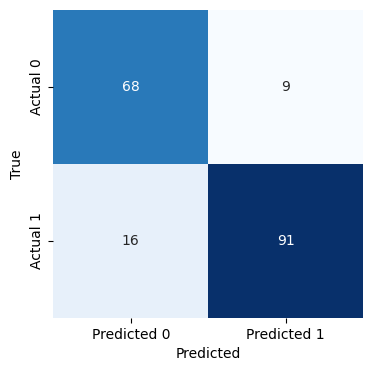

MODEL : Random Forest Classifier
-----------------------------------------------------------------------------------
TRAIN DATA
100.000 %
-----------------------------------------------------------------------------------
TEST DATA
87.500 %


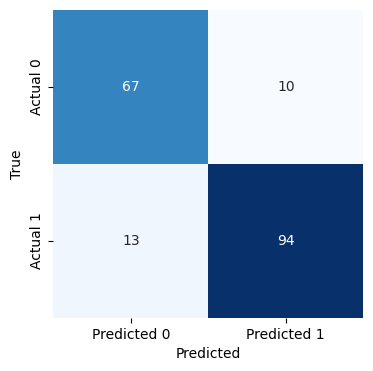

MODEL : Support Vector Classifier
-----------------------------------------------------------------------------------
TRAIN DATA
88.283 %
-----------------------------------------------------------------------------------
TEST DATA
84.239 %


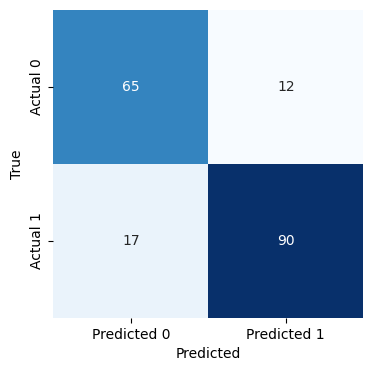

MODEL : XGBoost Classifier
-----------------------------------------------------------------------------------
TRAIN DATA
100.000 %
-----------------------------------------------------------------------------------
TEST DATA
85.326 %


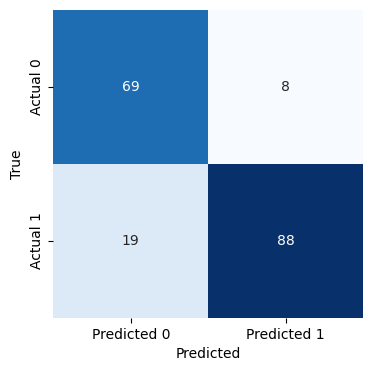

MODEL : LGBM Classifier
-----------------------------------------------------------------------------------
TRAIN DATA
100.000 %
-----------------------------------------------------------------------------------
TEST DATA
84.783 %


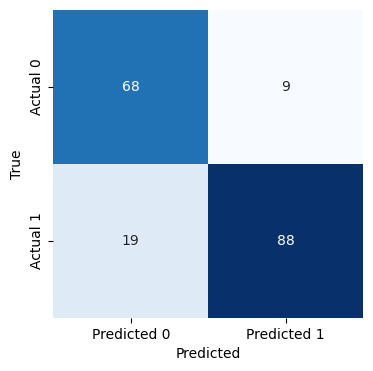

MODEL : CatBoost Classifier
-----------------------------------------------------------------------------------
TRAIN DATA
97.411 %
-----------------------------------------------------------------------------------
TEST DATA
88.587 %


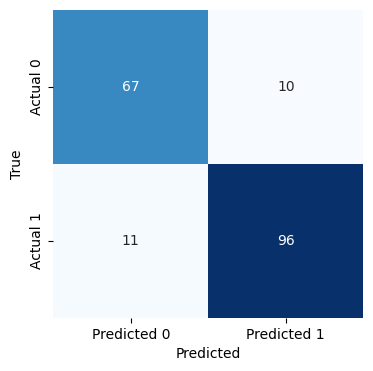

C:\Users\Akash\Desktop\machine-learning-end-to-end-projects\classification_new\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


MODEL : AdaBoost Classifier
-----------------------------------------------------------------------------------
TRAIN DATA
88.692 %
-----------------------------------------------------------------------------------
TEST DATA
85.870 %


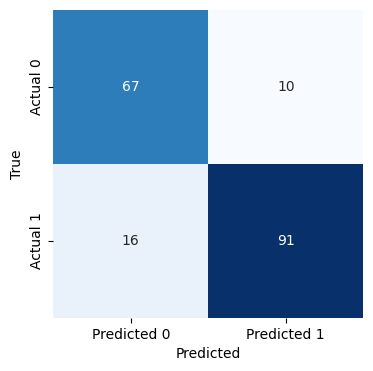

In [18]:
for model_name, model_object in classification_models.items():
    evaluate_model(model_object, model_name, train_features, test_features, train_target, test_target)

##### Observations:
- CatBoost Classifier is the model we will consider due to following reasons:
    - Highest test accuracy
    - Lest number of FN.

### Best Model Hyperparameter Tuning

In [78]:
# defining objective function
def objective(trial):
    '''In this objective function, we are trying to maximize recall score'''
    # defining hyperparameters
    parameters= {'iterations': trial.suggest_int('iterations', 100, 1000),
                 'depth': trial.suggest_int('depth', 4, 10),
                 'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
                 'random_strength': trial.suggest_float('random_strength', 0.01, 1.0),
                 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                 'border_count': trial.suggest_int('border_count', 32, 255),
                 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10)}
    # initializing the CatBoostClassifer
    model= CatBoostClassifier(**parameters,
                              verbose= False)
    model.fit(train_features, train_target, eval_set= (test_features, test_target))
    test_target_predictions= model.predict(test_features)
    # recall or sensitivity or true positive rate = (true positive)/(true positive + false negative)
    recall= recall_score(test_target, test_target_predictions)
    return recall

In [79]:
# creating a study
study= optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 100)

[I 2024-01-20 10:54:22,198] A new study created in memory with name: no-name-7cbbc99d-c159-44d1-97d9-907217f19625
[I 2024-01-20 10:54:27,125] Trial 0 finished with value: 0.8878504672897196 and parameters: {'iterations': 867, 'depth': 8, 'learning_rate': 0.084675056098678, 'random_strength': 0.5979855865520236, 'bagging_temperature': 0.7851847369246628, 'border_count': 87, 'l2_leaf_reg': 2.8960411622495204}. Best is trial 0 with value: 0.8878504672897196.
[I 2024-01-20 10:54:30,518] Trial 1 finished with value: 0.8785046728971962 and parameters: {'iterations': 338, 'depth': 9, 'learning_rate': 0.09389428106841677, 'random_strength': 0.923384842640152, 'bagging_temperature': 0.8724278926974582, 'border_count': 250, 'l2_leaf_reg': 2.602780534736097}. Best is trial 0 with value: 0.8878504672897196.
[I 2024-01-20 10:54:33,049] Trial 2 finished with value: 0.897196261682243 and parameters: {'iterations': 955, 'depth': 6, 'learning_rate': 0.0659406873108084, 'random_strength': 0.614290770870

In [80]:
best_parameters= study.best_params
print(f'Best Hyperparameters:\n{best_parameters}')

Best Hyperparameters:
{'iterations': 428, 'depth': 7, 'learning_rate': 0.020201227691164496, 'random_strength': 0.7400708896672612, 'bagging_temperature': 0.5271254575335044, 'border_count': 255, 'l2_leaf_reg': 5.2776107590361985}


In [81]:
best_model= CatBoostClassifier(**best_parameters,
                               verbose= False)
best_model.fit(train_features, train_target)
test_target_prediction= best_model.predict(test_features)

In [82]:
ACC= accuracy_score(test_target, test_target_prediction)
REC= recall_score(test_target, test_target_prediction)

In [83]:
print(f'ACC: {ACC*100:.3f} %\nREC: {REC*100:.3f} %')

ACC: 88.587 %
REC: 89.720 %


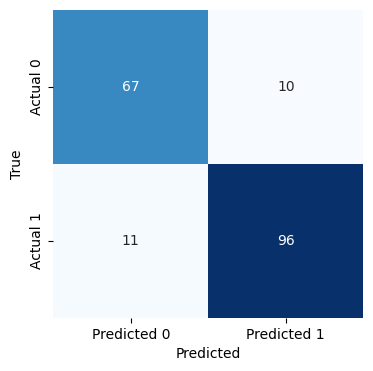

In [84]:
plot_CM(test_target, test_target_prediction)

#### Experimentation Log:
```python
Experiment 1:
CatBoostClassifier( ):

ACC: 88.587 %
REC: 89.720 %

Experiment 2:
CatBoostClassifier('iterations': 611, 
                   'depth': 8, 
                   'learning_rate': 0.03312655314709268,
                   'random_strength': 0.849836691558517, 
                   'bagging_temperature': 0.6139594655180022, 
                   'border_count': 190, 
                   'l2_leaf_reg': 7.853945265976367):

ACC: 88.043 %
REC: 89.720 

Experiment 3:
CatBoostClassifier('iterations': 140, 
                   'depth': 6, 
                   'learning_rate': 0.06103212591097244, 
                   'random_strength': 0.7146091182619464, 
                   'bagging_temperature': 0.7569038177960598, 
                   'border_count': 76, 
                   'l2_leaf_reg': 4.660597952852741):

ACC: 89.674 %
REC: 91.589 %%
```